# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним нам как раз и предлагается поработать в этом кейсе. 

> В нашем распоряжении будет набор данных, который содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.




## Данные и их описание

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



Импорт базовых библиотек:

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:

* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнайте, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнайте, из каких стран совершались транзакции.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

In [2]:
data = pd.read_csv(
    "data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
#основная информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


**По основной иформации видно, что числовые форматы имеют только два признака - "Quantity", "UnitPrice", также в данных имеются признаки**

In [4]:
#Проведем статистический анализ данных 
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


**По признакам количества товаров, и цены видны аномальные значения, в частности минимальное значение признака 'Quantity' по модулю соотвествует максимальному значению (оба значения крайне аномальные), у признака цены минимальное значение соответствует очень низкому отрицательному значению за еденицу товара**

In [5]:
#Фильтруем по максимальному и минимальному количеству товаров в транзакциях
data[(data['Quantity'] == -80995) | (data['Quantity']==80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446,United Kingdom


**Отфильтруя данные по минимальному и максимальному значениям можно понять что это отменненая, спустя 15 минут, транзакция, совершенная в Великобритании**

In [6]:
#Фильтруем по минимальному значению цены товара
data[data['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


**Также после фильтрации по минимальной цене, видно, что идущие следом друг за другом две транзакции, прошедшие в один день с интервалом в минуту в Великобритании с одинаковым кодом товара**

In [7]:
print(f'Количество транзакций с отрицательной ценой {data[data["UnitPrice"]<0].shape[0]}')

Количество транзакций с отрицательной ценой 2


**Получается, что две транзакции, выведенные мной выше, являются единственными с отрицательной ценой**

In [8]:
print(f'Количество отмененных транзакций с положительным значением в признаке количества товара {data[(data["InvoiceNo"].str.startswith("C")) & (data["Quantity"]>=0)].shape[0]}')
print(f"Количество транзакций одновременно с отрицательным количеством и нулевой ценой {data[(data['UnitPrice']==0) & (data['Quantity']<0)].shape[0]}")
print(f'Количество неотменненых транзакций с отрицательным количеством товаров {data[~(data["InvoiceNo"].str.startswith("C")) & (data["Quantity"]<0)].shape[0]}')
print(f'Количество транзакций с нулевой ценой {data[data["UnitPrice"]==0].shape[0]}')

Количество отмененных транзакций с положительным значением в признаке количества товара 0
Количество транзакций одновременно с отрицательным количеством и нулевой ценой 1336
Количество неотменненых транзакций с отрицательным количеством товаров 1336
Количество транзакций с нулевой ценой 2515


**Предварительно пришло понимание, что во всех отменненых транзакциях количество товаров меньше нуля. Отрицательное количество товаров также имеется и в неотменненых транзакциях, в этих же транзакциях и отрицательная цена**

In [9]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


In [10]:
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [11]:
print(f'Количество стран в наборе данных составляет {data["Country"].nunique()}')

Количество стран в наборе данных составляет 38


## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалите их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [12]:
print(f'Количество пропущенных данных до очистки данных {data.isnull().sum().sum()}')
print(f'Признаки с нулевыми значениями :{[col for col in data.columns if data[col].isnull().sum()>0]}')

Количество пропущенных данных до очистки данных 136534
Признаки с нулевыми значениями :['Description', 'CustomerID']


In [13]:
#Удвляем строки из CustomerID 
data.dropna(inplace=True)

In [14]:
print(f'Количество пропущенных данных после очистки данных {data.isnull().sum().sum()}')
print('Осталось строк в таблице:', data.shape[0])
print(f'В данных {data["CustomerID"].nunique()} уникальных клиентов')

Количество пропущенных данных после очистки данных 0
Осталось строк в таблице: 406829
В данных 4372 уникальных клиентов


#### 2.1.2. Дубликаты

Проверьте данные на наличие дубликатов. Удалите их из данных.


In [15]:
print(f'Количество дубликатов в данных составляет {data[data.duplicated()].shape[0]}')

Количество дубликатов в данных составляет 5225


In [16]:
#Удаляем пропуски 
data.drop_duplicates(inplace=True)

In [17]:
print('Осталось строк в таблице:', data.shape[0])

Осталось строк в таблице: 401604


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [18]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [19]:
print(f"Количество возвратов составляет {np.round(nb_products_per_basket[nb_products_per_basket['InvoiceNo'].str.startswith('C')].shape[0] / nb_products_per_basket['Number of products'].shape[0] * 100,1)} %")

Количество возвратов составляет 16.5 %


**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создайте в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента мы подготовили для вас функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). При желании вы можете самостоятельно модифицировать функцию для предобработки, чтобы учесть этот пограничный случай.

*Осторожно! Поиск отменённых транзакций занимает много времени из-за большого количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от мощности компьютера.*

In [20]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

*Осторожно! Поиск отмененных транзакций занимает достаточно длительное время из-за количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от компьютера.*

Узнайте, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалите их из данных.

Когда вы разобрались с возвратами, удалите транзакции с отрицательным количеством товара — они нам больше не нужны.



In [22]:
print(f"Количество транзакций неимеющих контрагентов составляет {data['QuantityCanceled'].isnull().sum()}")
print(f"Доля относительно всего датасета транзакций без контрагента составляет {round(data['QuantityCanceled'].isnull().sum()/data.shape[0] *100,2)} %")

Количество транзакций неимеющих контрагентов составляет 1303
Доля относительно всего датасета транзакций без контрагента составляет 0.32 %


**Количество записей с отсутствующим контрагентом составляет меньше одного процента от всего набора данных, и поэтому можно эти записи удалить**

In [23]:
data.dropna(inplace=True)

In [24]:
# Удаляем транзакции с отрицательным количеством товара
data.drop(data[data['Quantity'] <0].index,inplace=True)

#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

**Подсказка.** В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'.

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

In [25]:
pattern = r'^[a-zA-Z]+'
print(f"Количество транзакций со специальными операциями составляет {data[data['StockCode'].str.match(pattern)].shape[0]}")
print(f"Уникальные специальные виды транзакций {data[data['StockCode'].str.match(pattern)]['StockCode'].unique()}")
print(f"Количество уникальных специальных видов транзакций составляет' {data[data['StockCode'].str.match(pattern)]['StockCode'].nunique()}")

#Удаляю специальные транзакции
data = data[~data['StockCode'].str.match(pattern)]

Количество транзакций со специальными операциями составляет 1549
Уникальные специальные виды транзакций ['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']
Количество уникальных специальных видов транзакций составляет' 6


In [26]:
print('Осталось строк в таблице:', data.shape[0])

Осталось строк в таблице: 391183


#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [27]:
print(f"Количество транзакций с нулевой ценой составляет {round(data[data['UnitPrice'] == 0].shape[0] / data.shape[0] * 100,3)}")

Количество транзакций с нулевой ценой составляет 0.008


In [28]:
data.drop(data[data['UnitPrice'] == 0].index,inplace=True)

In [29]:
print('Осталось строк в таблице:', data.shape[0])

Осталось строк в таблице: 391150


#### 2.1.6. Общая стоимость товаров в транзакции

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [30]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

Помимо рекомендованных преобразований, вы также можете придумать собственные и применить их к исходным данным.
После завершения предобработки сохраните результат очищения данных в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.


### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



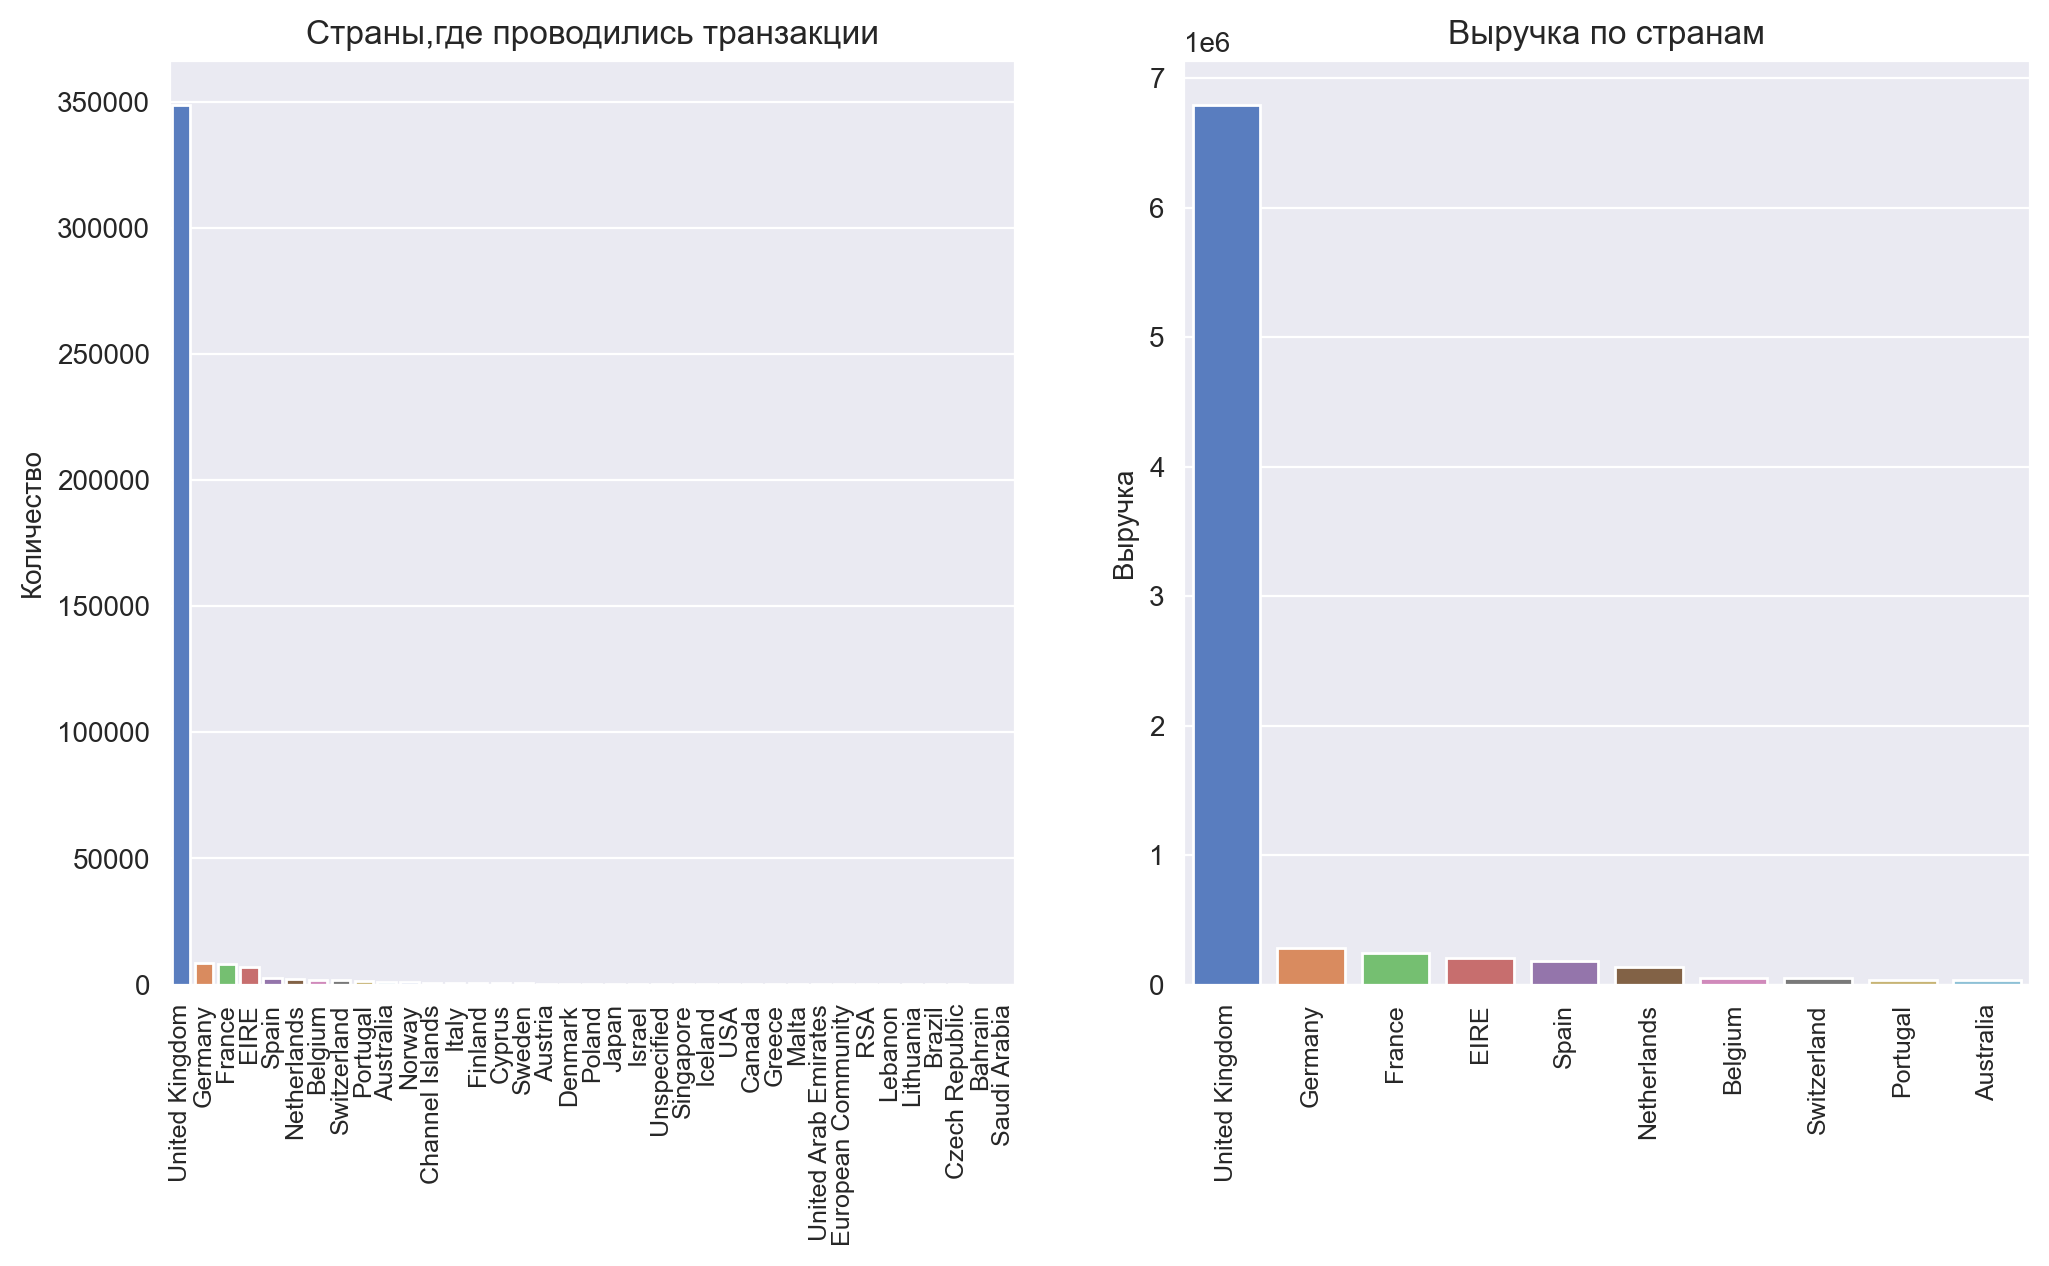

In [31]:
#Построим столбчатую диаграмму, для анализа покупки с разных стран
countries = data['Country'].value_counts().reset_index()
sns.set_style('darkgrid')


fig,axes = plt.subplots(1,2,figsize=(12,6),dpi=200)
sns.barplot(data=countries,x='Country',y='count',palette='muted',ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(countries['Country'].unique(),rotation=90,fontsize=9)
axes[0].set_title('Страны,где проводились транзакции')


country_price = data.groupby('Country')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice',ascending=False).iloc[:10]

sns.barplot(data=country_price,x='Country',y='TotalPrice',palette='muted',ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Выручка')
axes[1].set_xticklabels(countries['Country'].unique(),rotation=90,fontsize=9)
axes[1].set_title('Выручка по странам')
plt.show()

**Подавляющее большинство клиентов проживает в Великобритании,также среди стран имеется неизвестная страна 'Unspecified'.Также по выручке, ввиду многочисленности клиентов, также приносит Великобритания**

In [32]:
#выделим временные признаки для анализа
data['InvoiceHour'] = data['InvoiceDate'].dt.hour
data['InvoiceMonth'] = data['InvoiceDate'].dt.month
data['InvoiceDay'] = data['InvoiceDate'].dt.day_of_week
data['InvoiceQuarter'] = data['InvoiceDate'].dt.quarter

**По графику видно, что выручка приносится, как правило, в утреннее время, и в обеденное время. Реже всего транзакции проходят в ночное время**

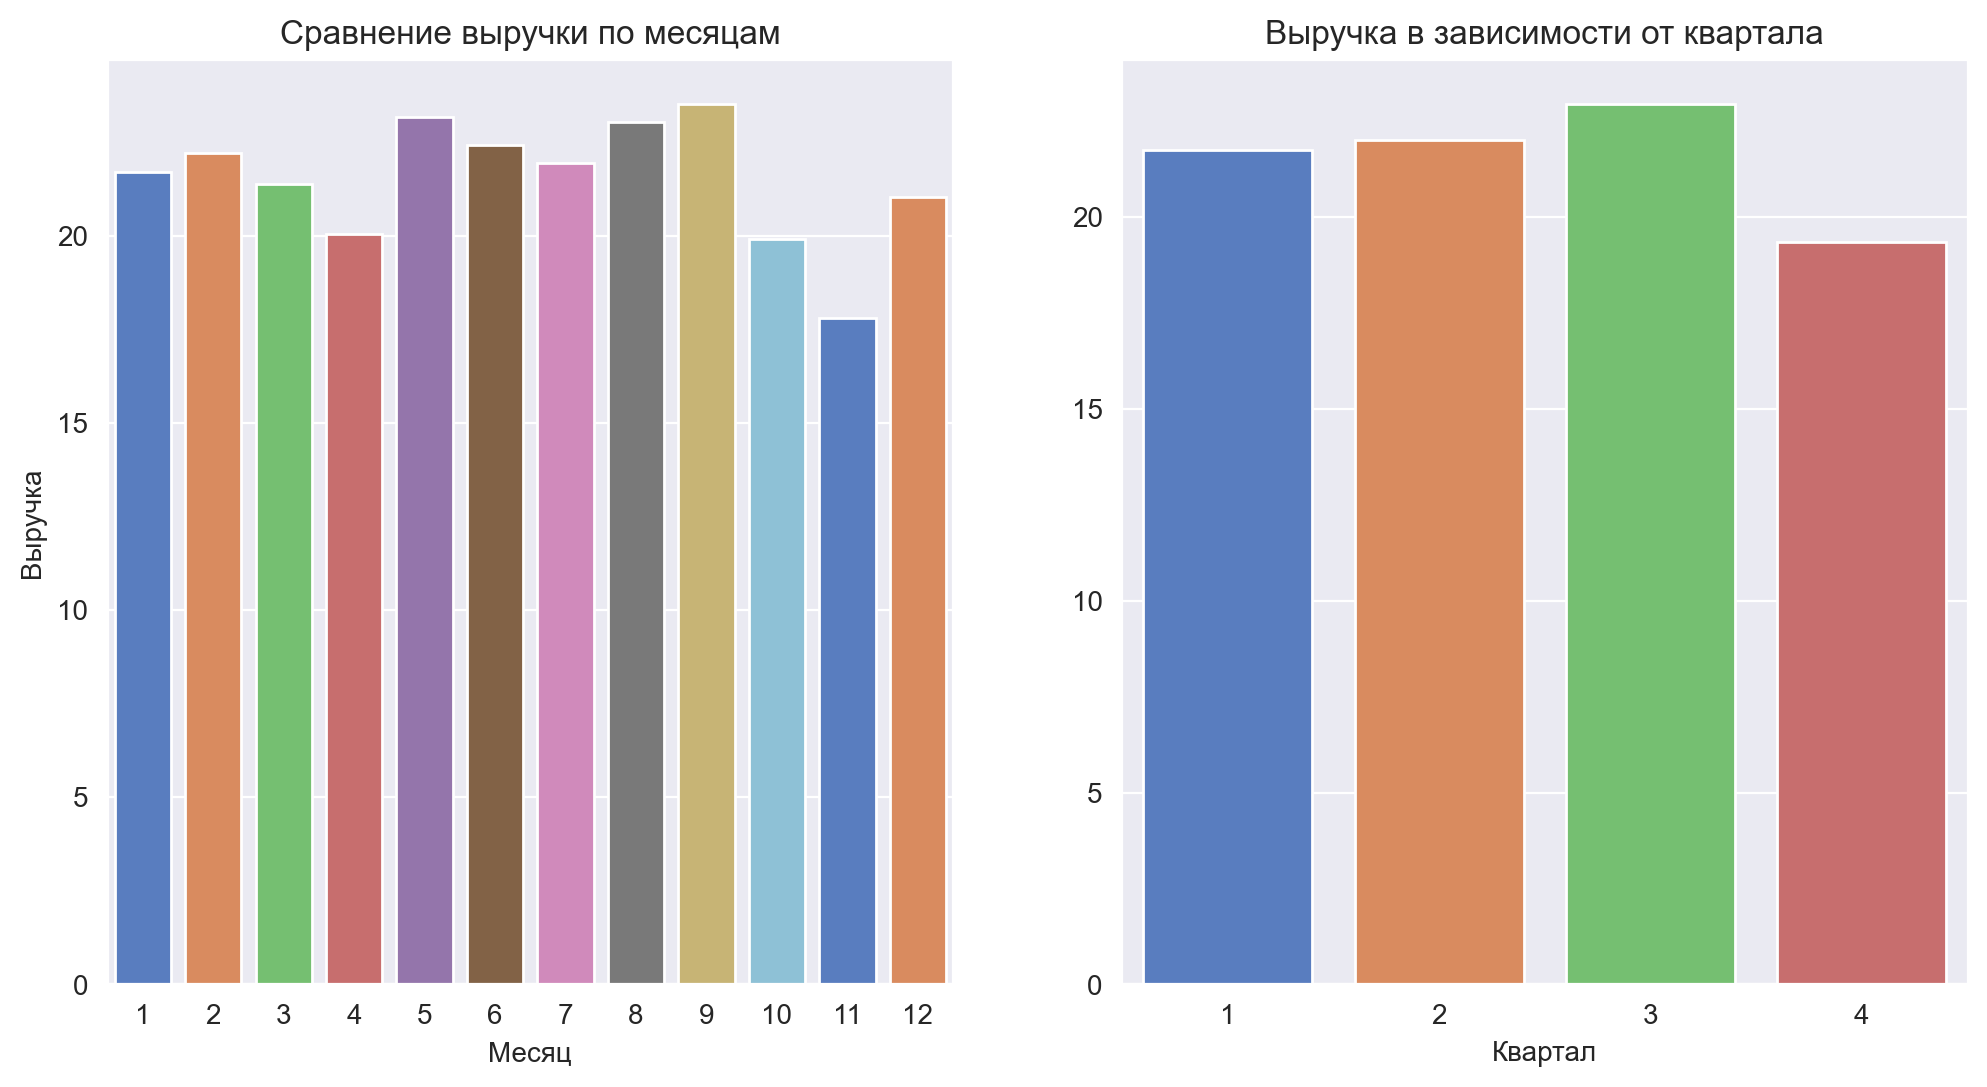

In [33]:
fig,axes = plt.subplots(1,2,figsize=(12,6),dpi=200)

#График сравнения выручки по месяцам
sns.barplot(data=data,x='InvoiceMonth',y='TotalPrice',palette='muted',ci=None, ax=axes[0])
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Выручка')
axes[0].set_title('Сравнение выручки по месяцам')

#График сравнения выручки по временному кварталу
sns.barplot(data=data,x='InvoiceQuarter',y='TotalPrice',palette='muted',ci=None, ax=axes[1])
axes[1].set_xlabel('Квартал')
axes[1].set_ylabel('')
axes[1].set_title('Выручка в зависимости от квартала')
plt.show()

**Кардинальная разница в выручке в зависимости от месяца или квартала не выявлена. Некоторый спад активности наблюдается в октябре, ноябре или в четвертом квартале, однако разница не значительна**

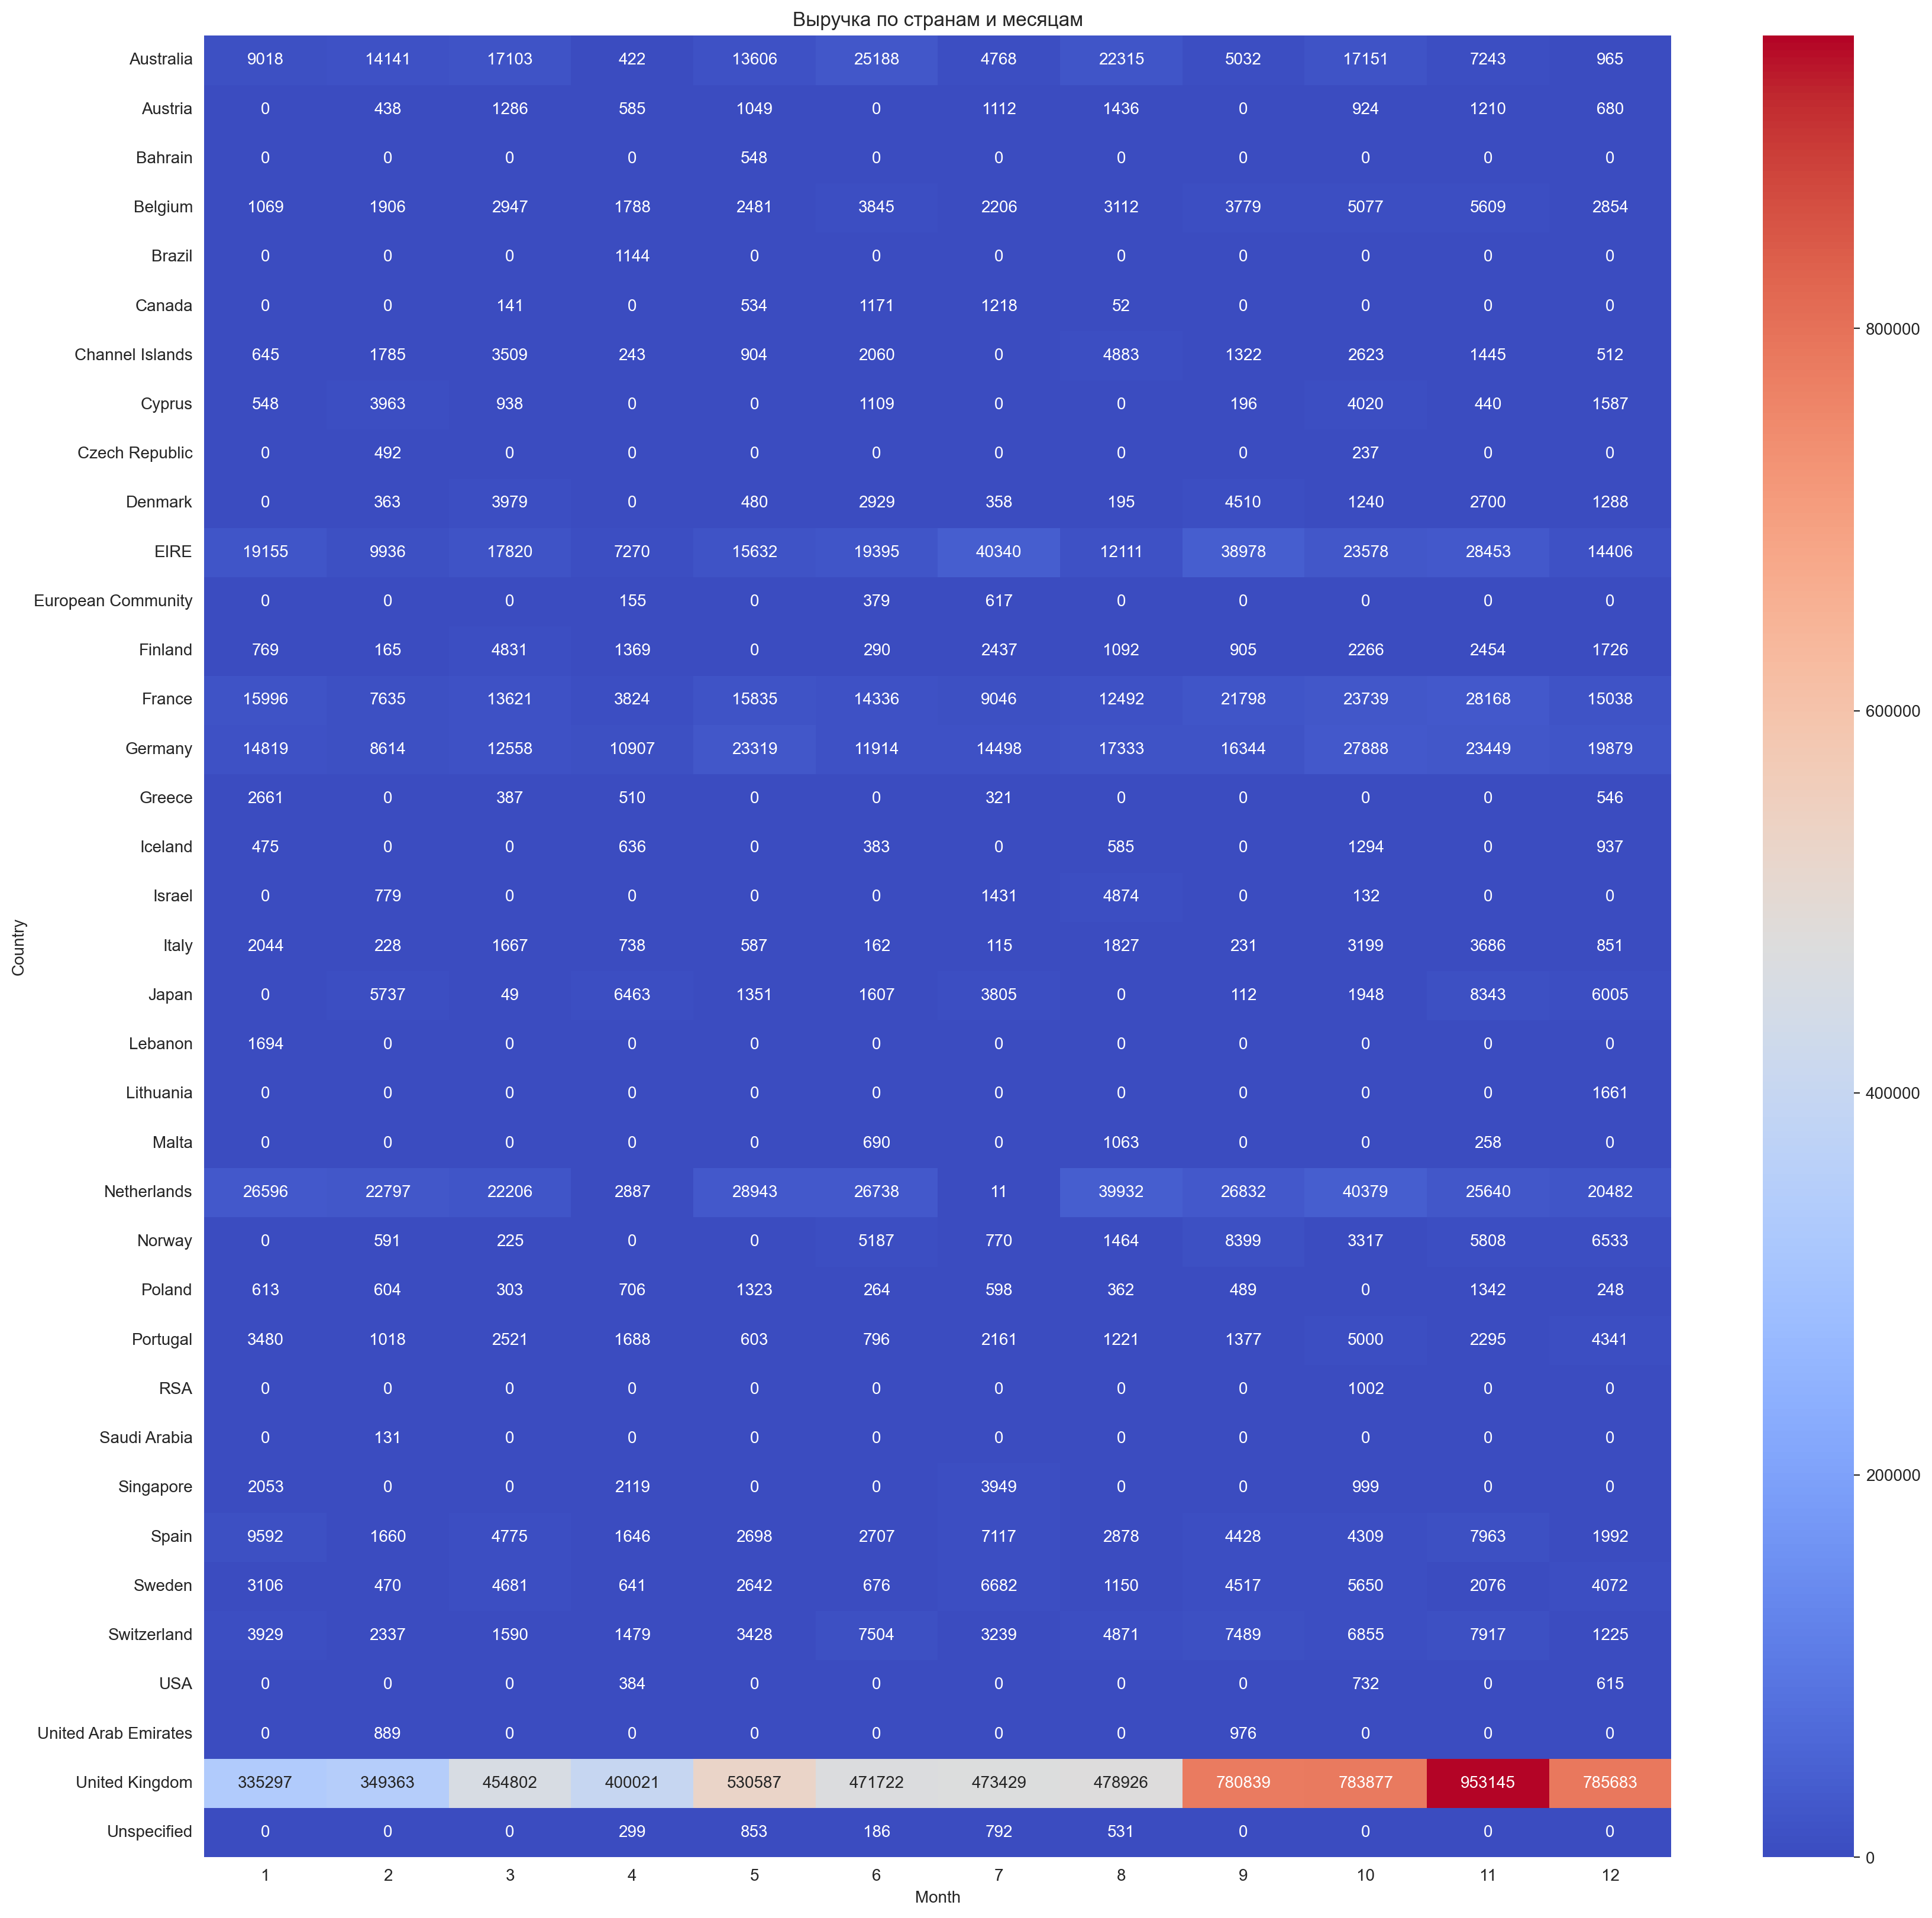

In [34]:
season_table = data.pivot_table(values='TotalPrice',index='Country',columns='InvoiceMonth',aggfunc='sum',fill_value=0)

# Построение тепловой карты
plt.figure(figsize=(20, 20),dpi=200)
sns.heatmap(season_table, annot=True, cmap='coolwarm',fmt=".0f")
plt.title('Выручка по странам и месяцам')
plt.xlabel('Month')
plt.ylabel('Country')
plt.show()

**А вот при построении тепловой карты по суммарной выручке по странам, можно заметить, что примерно с сентября по декабрь для некоторых стран, можно заметить подъем выручки, например для Великобритании и Нидерланд**

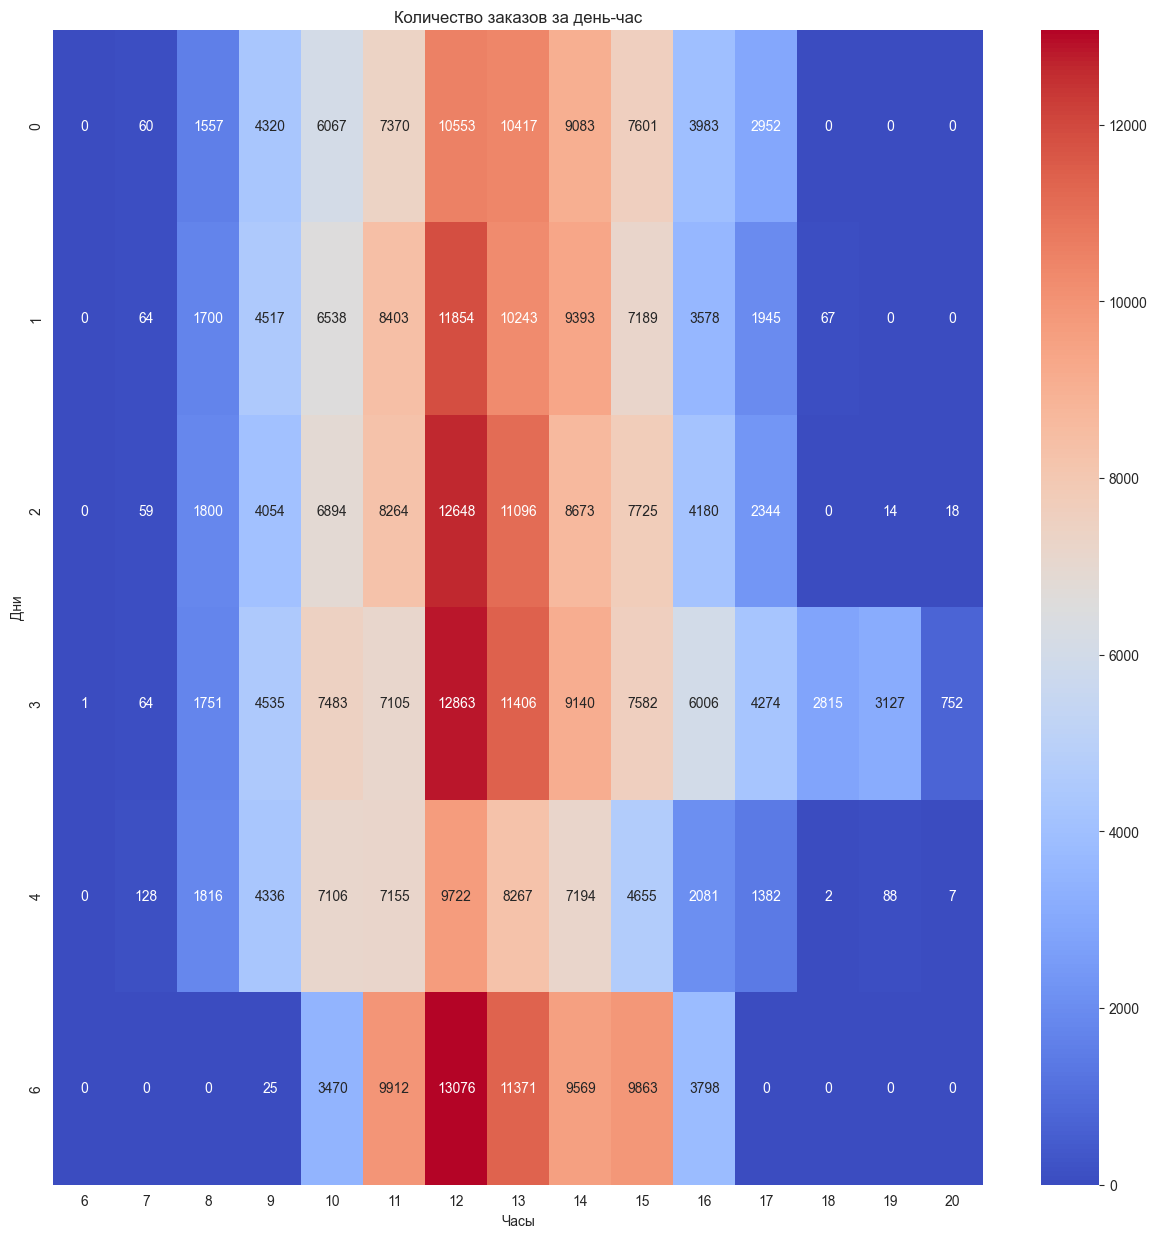

In [35]:
dayHour_table = data.pivot_table(values='InvoiceNo',index='InvoiceDay',columns='InvoiceHour',aggfunc='count',fill_value=0)
plt.figure(figsize=(15, 15))
sns.heatmap(dayHour_table, annot=True, cmap='coolwarm',fmt=".0f")
plt.title('Количество заказов за день-час')
plt.xlabel('Часы')
plt.ylabel('Дни')
plt.show()

**По графику можно заметить отсутсвие транзакционных операций в субботу. Также можно заметить, что активность клиентов проявляется обычно каждый день в 12 дня (в пятницу идет на спад, в субботу вовсе нет, пик активности - в воскресение). Также активность клиентов, но уже чуть меньше, проявляется также и в 13:00 и в 14:00. Также можно заметить, что клиенты всегда активны в четверг во все часы**

In [36]:
df = data.groupby(['InvoiceDay','InvoiceHour'])['InvoiceNo'].count().reset_index().rename(columns={'InvoiceNo':'count'})
df = df.groupby('InvoiceHour')['count'].mean().reset_index()

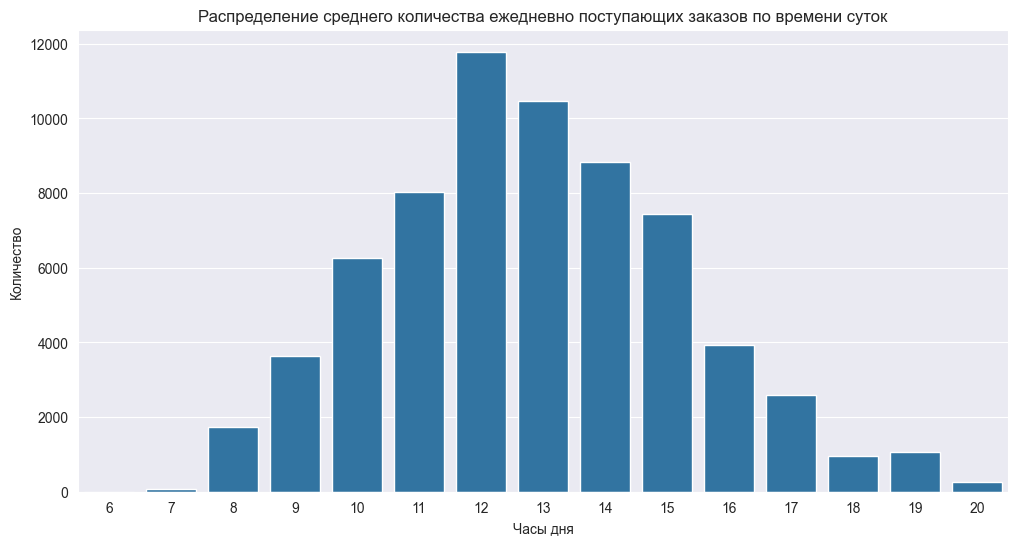

In [37]:
plt.figure(figsize=(12,6))
sns.barplot(data=df,x='InvoiceHour',y='count')
plt.title('Распределение среднего количества ежедневно поступающих заказов по времени суток')
plt.xlabel('Часы дня')
plt.ylabel('Количество')
plt.show()

**Как отмечалось ранее большая часть заказов проходит в 12 часов дня, далее начинает снижаться. В вечернее время и в утреннее время, как правило, не заказывают**

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [38]:
#Сгруппируем данные по клиентам, рассчитаем максимальную дату для них
rfm_table = data.groupby('CustomerID')['InvoiceDate'].max().reset_index().rename(columns={"InvoiceDate":"Recency"})
#Рассчитаем Recency, отняв из даты-"точки отсчета" максимальные даты
rfm_table['Recency'] = (pd.to_datetime('2011-12-10 00:00:00') - rfm_table['Recency']).dt.days

#Рассчитаем количество уникальных заказов для каждого клиента
rfm_table['Frequency'] = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()['InvoiceNo']

#Рассчитаем общую сумму денег для каждого клиента, которую он потратил на товары
rfm_table['Monetary'] = data.groupby('CustomerID')['TotalPrice'].sum().reset_index()['TotalPrice']

In [39]:
print('Количество клиентов, совершивших покупку более 200 дней назад:', rfm_table[rfm_table['Recency']>200].shape[0])
print('Среднее количество заказов:', round(rfm_table['Frequency'].mean()))
print('Общая сумма потраченных денег клиентом с идентификатором 12360:', round(rfm_table[rfm_table['CustomerID'] == '12360']['Monetary'].iloc[0]))


Количество клиентов, совершивших покупку более 200 дней назад: 743
Среднее количество заказов: 4
Общая сумма потраченных денег клиентом с идентификатором 12360: 2302


In [41]:
#Удалим признак клиента, поскольку не пригодится в построении модели
rfm_table.drop(columns='CustomerID',inplace=True)

После того как вы подготовите RFM-таблицу, визуализируйте каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot). Вы получите примерно следующие результаты (графики могут отличаться в зависимости от того, как вы выполните предобработку данных):

In [42]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [43]:
#создадим переменные с квантилем уровня 0.95
freq_quantile = rfm_table['Frequency'].quantile(0.95)
monetary_quatile = rfm_table['Monetary'].quantile(0.95)

#Обозначим как выбросы, данные, которые выше порога квантиля 0.95 
outliers = rfm_table[(rfm_table['Frequency'] > freq_quantile) | (rfm_table['Monetary'] > monetary_quatile)]

#Удалим выбросы
rfm_table.drop(outliers.index, inplace=True)

print('Количество строк после удаления выбросов составляет', rfm_table.shape[0])

Количество строк после удаления выбросов составляет 4044


## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать. Для удобства оберните эти шаги по предобработке данных в pipeline.

Произведите предобработку исходных данных. На основе RFM-признаков кластеризуйте клиентов онлайн-магазина подарков с помощью известных вам методов (используйте минимум три метода).

Подберите оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга). 

Выберите алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.


In [44]:
#Применим pipeline, в котором будет методы стандартизации и уменьшения размерности признаков
pipeline = Pipeline(steps=[('scaler',StandardScaler()),
                            ('pca',PCA(n_components=2))])
pipeline.fit(rfm_table)

rfm_table_norm = pipeline.transform(rfm_table)

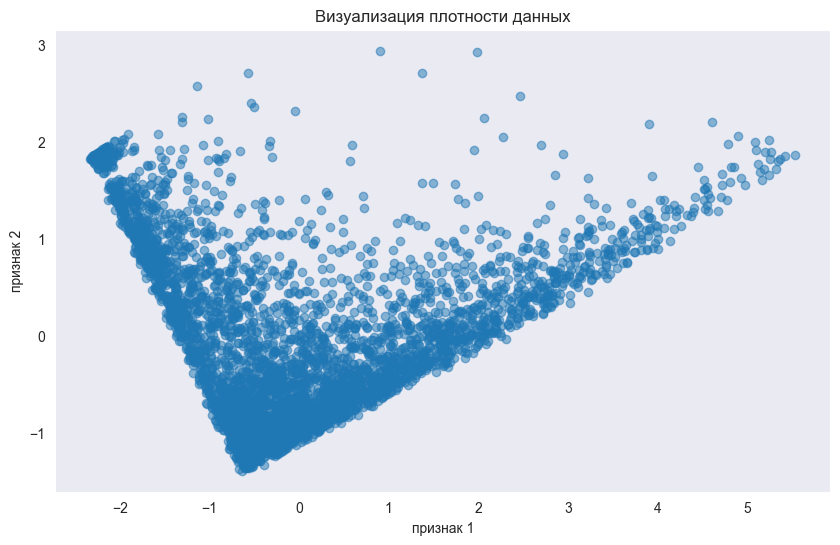

In [45]:
# Визуализация точечного графика
plt.figure(figsize=(10, 6))
plt.scatter(rfm_table_norm[:, 0], rfm_table_norm[:, 1],alpha=0.5)
plt.title("Визуализация плотности данных")
plt.xlabel("признак 1")
plt.ylabel("признак 2")
plt.grid()
plt.show()

**Данные представлены в интересной форме, точки расположены близко друг другу, но есть и точки которые несколько удалены от всех остальных. Потенциально такой метод кластеризации как DBSCAN может определить данные точки как шумовые, и поэтому данный метод может не подойти. Также было бы не просто подобрать такие параметры, как "eps" и min_samples. Поэтому, думаю, что лучше всего будет воспользоваться такими методами, как KMEANS, Agglomerative clustering и Gaussian Mixture**

### KMEANS

In [46]:
#Применим Kmeans 
silhouette_kmeans = []

for i in range(3,11):
    kmeans = KMeans(n_clusters=i,random_state=42)
    kmeans.fit(rfm_table_norm)
    score = silhouette_score(rfm_table_norm,kmeans.labels_)
    silhouette_kmeans.append((i,score))

best_result_kmeans =  sorted(silhouette_kmeans,key=lambda x: -x[1])[0]
print('Оптимальное количество кластеров {}, показатель силуэта kmeans {:.2f}'.format(best_result_kmeans[0],best_result_kmeans[1]))

Оптимальное количество кластеров 3, показатель силуэта kmeans 0.52


In [47]:
#Оставим в списке только коэффициент силуэта
silhouette_kmeans = [element[1] for element in silhouette_kmeans]

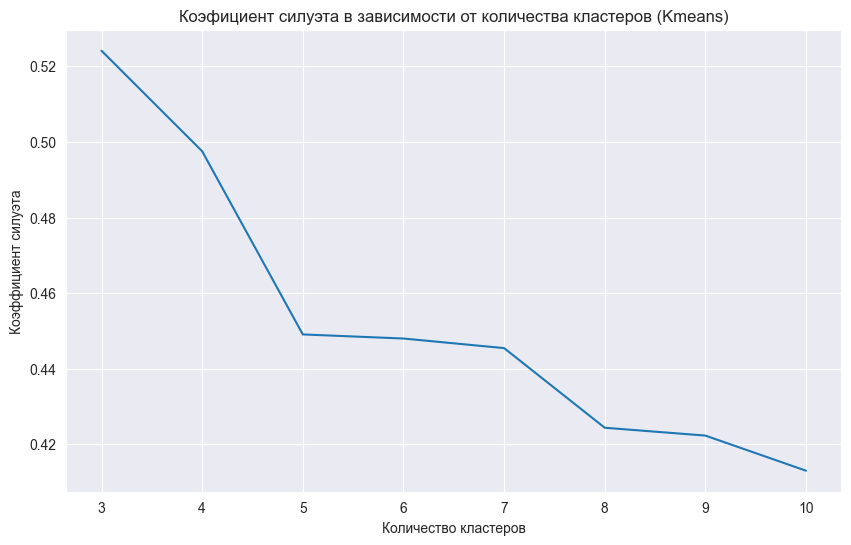

In [48]:
#Визуализируем метод силуэта
plt.figure(figsize=(10,6))
plt.plot(range(3,11),silhouette_kmeans)
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэфициент силуэта в зависимости от количества кластеров (Kmeans)')
plt.show()

### Agglomerative_clustering 

In [49]:
silhouette_agglomerative = []

for i in range(3,11):
    agglomerative = AgglomerativeClustering(n_clusters=i)
    agglomerative.fit(rfm_table_norm)
    score = silhouette_score(rfm_table_norm,agglomerative.labels_)
    silhouette_agglomerative.append((i,score))
    
best_result_agglomerative =  sorted(silhouette_agglomerative,key=lambda x: -x[1])[0]
print('Оптимальное количество кластеров {}, показатель силуэта agglomerative_clustering {:.2f}'.format(best_result_agglomerative[0],best_result_agglomerative[1]))

Оптимальное количество кластеров 3, показатель силуэта agglomerative_clustering 0.50


In [50]:
#Оставим в списке только коэффициент силуэта
silhouette_agglomerative = [element[1] for element in silhouette_agglomerative]

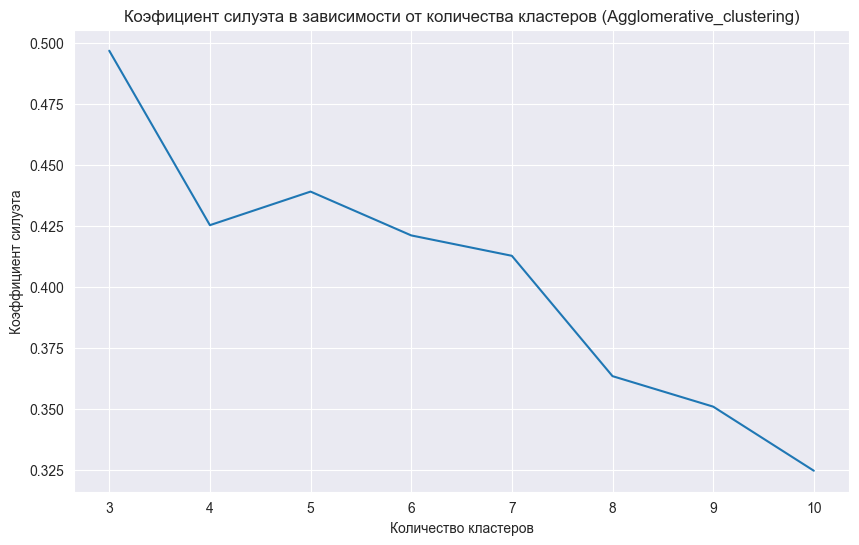

In [51]:
#Визуализируем метод силуэта
plt.figure(figsize=(10,6))
plt.plot(range(3,11),silhouette_agglomerative)
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэфициент силуэта в зависимости от количества кластеров (Agglomerative_clustering)')
plt.show()

### Gaussian mixture

In [52]:
silhouette_gaussian = []

for i in range(3,11):
    gaus = GaussianMixture(n_components=i)
    gaus.fit(rfm_table_norm)
    labels = gaus.predict(rfm_table_norm)
    score = silhouette_score(rfm_table_norm,labels)
    silhouette_gaussian.append((i,score))
    
best_result_gaussian =  sorted(silhouette_gaussian,key=lambda x: -x[1])[0]
print('Оптимальное количество кластеров {}, показатель силуэта gaussian_mixture {:.2f}'.format(best_result_gaussian[0],best_result_gaussian[1]))

Оптимальное количество кластеров 3, показатель силуэта gaussian_mixture 0.44


In [53]:
#Оставим в списке только коэффициент силуэта
silhouette_gaussian = [element[1] for element in silhouette_gaussian]

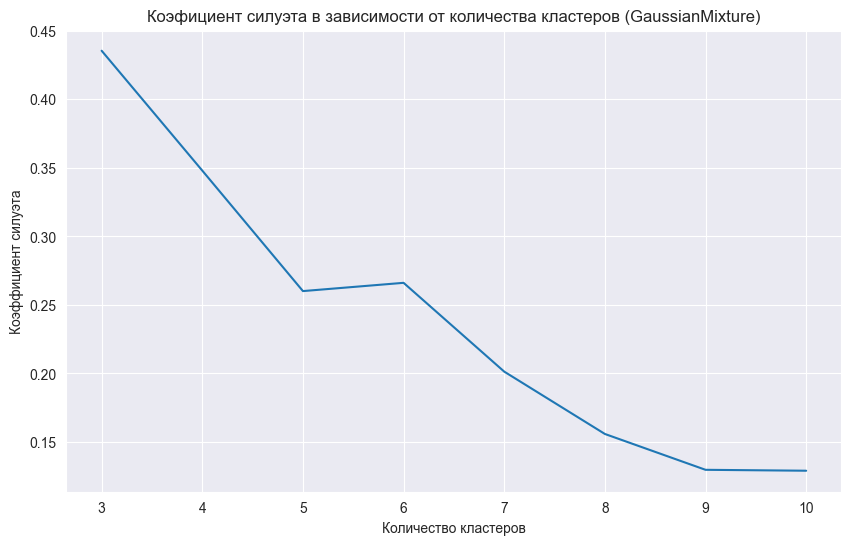

In [54]:
#Визуализируем метод силуэта
plt.figure(figsize=(10,6))
plt.plot(range(3,11),silhouette_gaussian)
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэфициент силуэта в зависимости от количества кластеров (GaussianMixture)')
plt.show()

**Лучше всего справился метод Kmeans с его результатом метрики силуэта**

In [55]:
print(f'Коэффициент силуэта составляет при использования метода Kmeans {round(max(silhouette_kmeans),2)}')

Коэффициент силуэта составляет при использования метода Kmeans 0.52


In [56]:
#Применение модели Kmeans и присоеденим к стандартизированным признакам для последующей визуализации 
best_model = KMeans(n_clusters=3,random_state=42)
best_model.fit(rfm_table_norm)
labels = best_model.predict(rfm_table_norm)
rfm_with_labels = np.concatenate([rfm_table_norm,labels.reshape(-1,1)],axis=1)

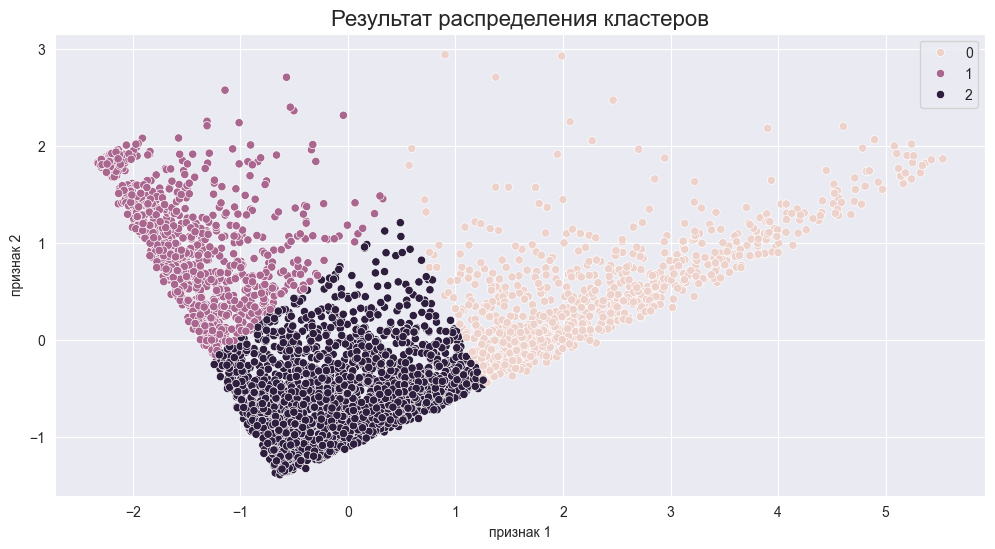

In [63]:
#Визуализируем распределение кластеров
plt.figure(figsize=(12,6))
sns.scatterplot(x = rfm_with_labels[:,0],y=rfm_with_labels[:,1],hue=rfm_with_labels[:,2].astype(int))
plt.xlabel("признак 1")
plt.ylabel("признак 2")
plt.title('Результат распределения кластеров',fontsize=16)
plt.show()

### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

In [66]:
rfm_table['labels'] = labels

,Recency,Frequency,Monetary,labels
0,325,1,0.00,1
1,2,7,4310.00,0
2,75,4,1437.24,2
3,18,1,1457.55,2
4,310,1,294.40,1
...,...,...,...,...
4328,73,1,173.90,2
4329,277,1,180.60,1
4330,180,1,80.82,1
4331,7,2,176.60,2


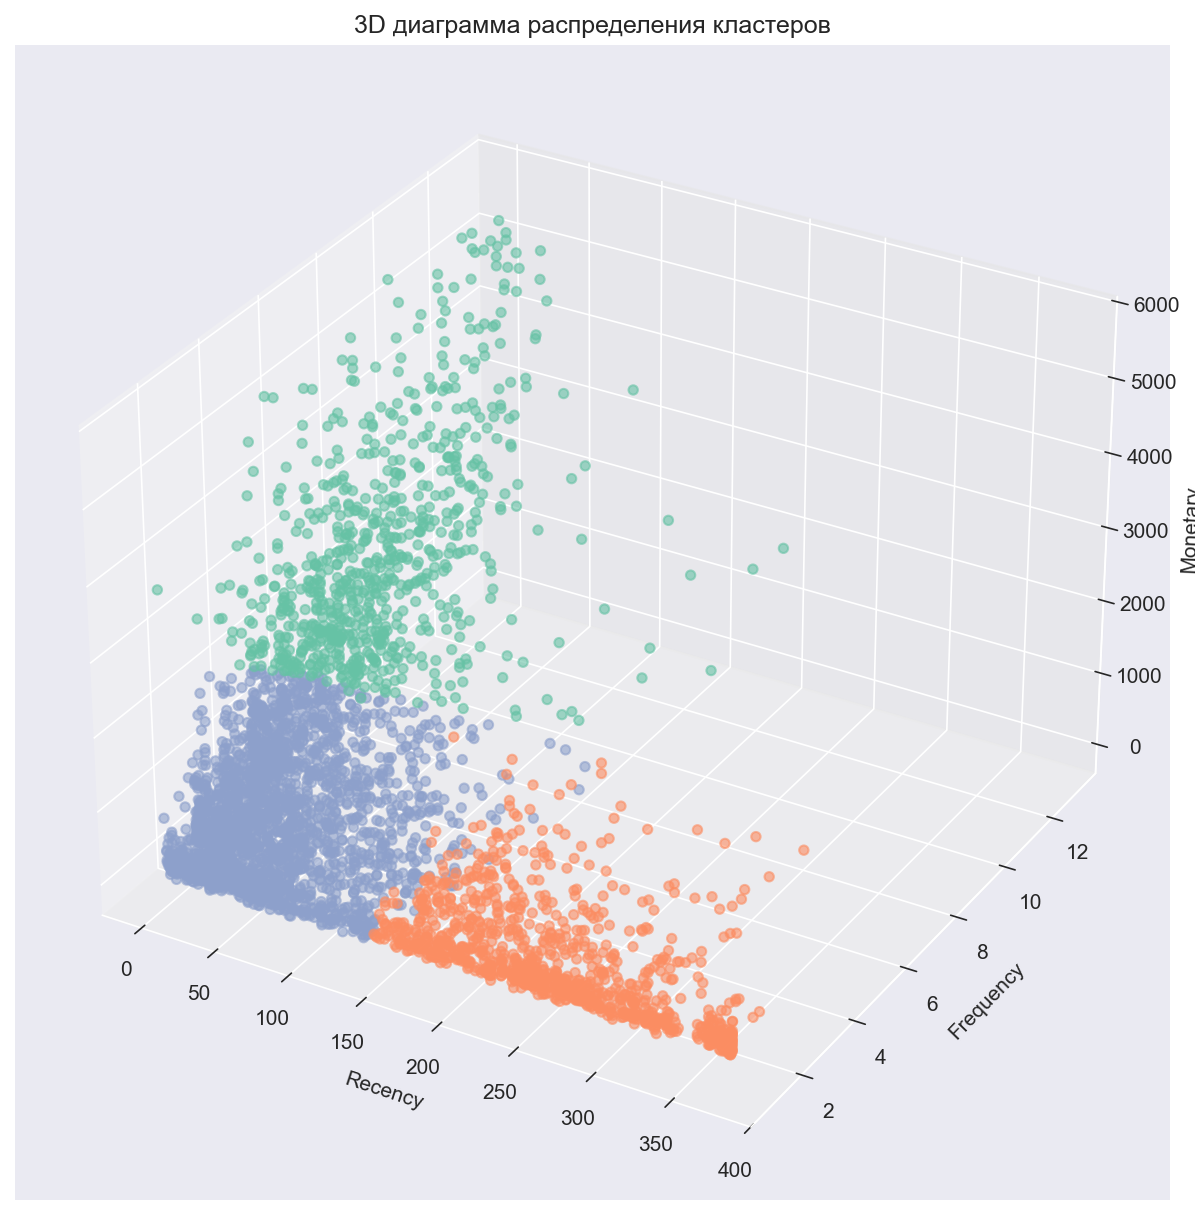

In [80]:
fig = plt.figure(figsize=(15, 10),dpi=150)
ax = fig.add_subplot(111, projection='3d')
# Задаем цвета для кластеров
colors = sns.color_palette("Set2", len(rfm_table['labels'].unique()))

# Отображаем точки на графике
for cluster in rfm_table['labels'].unique():
    cluster_data = rfm_table[rfm_table['labels'] == cluster]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'],
               color=colors[cluster], label=f'Cluster {cluster}', alpha=0.6)
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.set_title('3D диаграмма распределения кластеров')

In [82]:
#Посмтрим количественное распределение кластеров
rfm_table['labels'].value_counts()

labels
2    2270
1    1001
0     773
Name: count, dtype: int64

In [ ]:
#Создам датафрейм для построения круговой диаграммы
pie_chart_data = rfm_table.groupby('labels')['Frequency'].mean().reset_index()

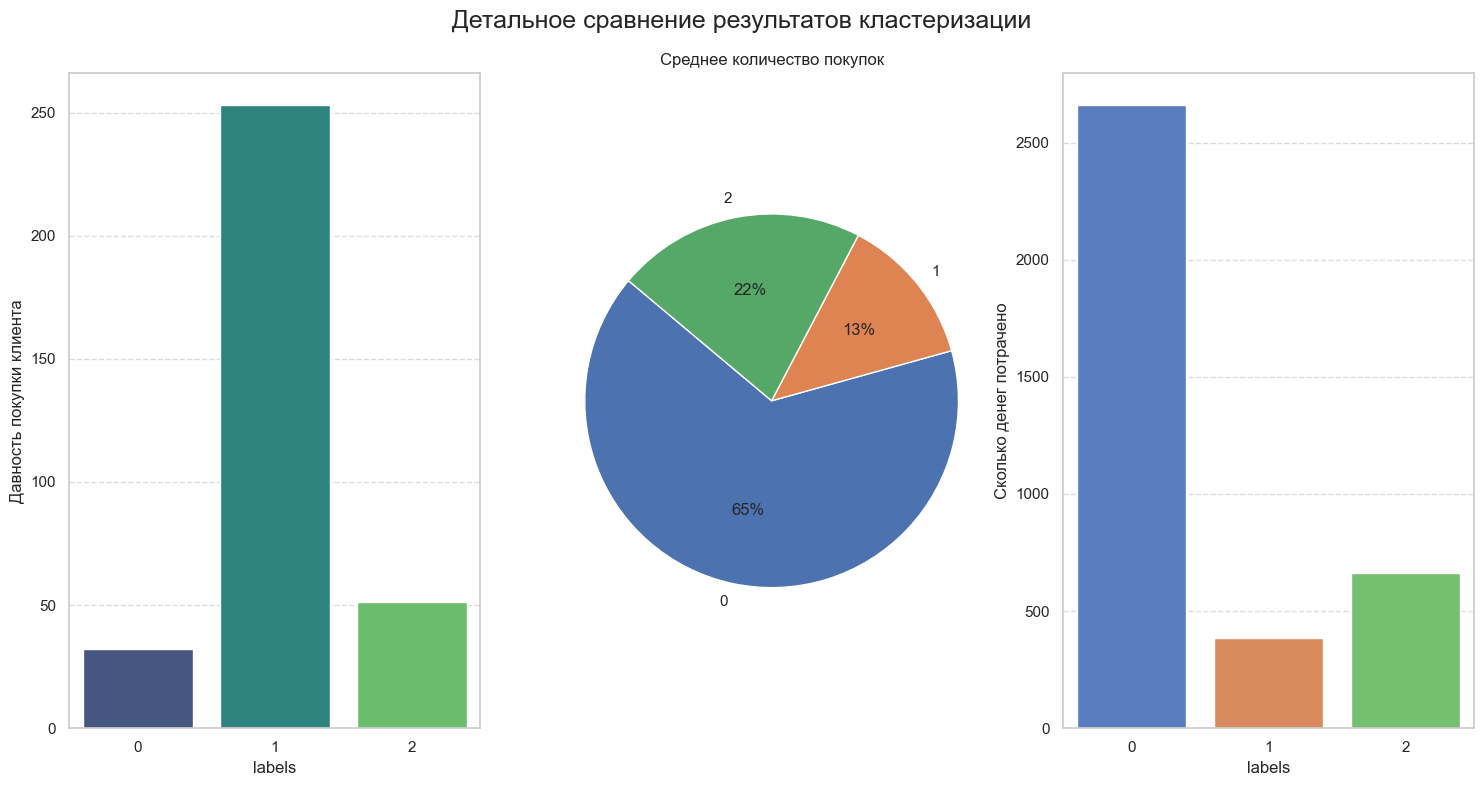

In [ ]:
#Для дополнительного анализа создам графики для сравнения групп (меток кластера) по трем критериям
sns.set(style="whitegrid")
plt.suptitle('Детальное сравнение результатов кластеризации',fontsize=18)

sns.barplot(data=rfm_table, x='labels',y='Recency',ci=None, palette='viridis', ax=axes[0])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_ylabel('Давность покупки клиента')
axes[1].pie(pie_chart_data['Frequency'], labels=pie_chart_data['labels'], autopct='%1.0f%%', startangle=140)
axes[1].set_title('Среднее количество покупок')
axes[1].axis('equal')
sns.barplot(data=rfm_table, x='labels',y='Monetary',palette='muted',ci=None, ax=axes[2])
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].set_ylabel('Сколько денег потрачено')
plt.tight_layout()

**Самой многочисленной группой является группа с меткой кластера "2", они отличаются тем, что у них давность покупки не превышает 50 дней, невысокое количество покупок, суммарная трата на покупки не превышает 1000 фунтов стерлингов. Следущие по численности идут группа с меткой кластера "1", самая неактивная группа, которые, возможно, не заинтересованы покупать. Давность последней покупки очень большой, количество покупок очень низкое, также низкие затраты. Самая меньшая по численности группа, однако, самая активная, группа "0". Давность покупки не большая, постоянно, что-то покупают, и тратят много на покупки**

#### 3.2.2. Построение профиля кластеров

Далее составьте так называемый профиль кластеров. Для этого вам необходимо вернуться от декомпозированных данных (если вы производили понижение размерности) к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, давайте познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На этой диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие этому кластеру, в большей степени увлекаются музыкой (Music), а в меньшей — программированием (Programm).

В модуле `graph_objects` библиотеки `plotly` есть встроенная функция `Scatterpolar`, которая позволяет построить полярную диаграмму. На основе этой функции мы подготовили для вас функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У неё есть два параметра: `grouped_data` — сгруппированные по кластерам характеристики объектов (клиентов), `n_clusters` — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в функцию `plot_cluster_profile()`.


In [130]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

Теперь у вас есть удобный инструмент для анализа профиля кластеров. Воспользуйтесь им, чтобы проинтерпретировать результаты, полученные на предыдущем шаге.

In [147]:
grouped_data = rfm_table.groupby('labels').mean()
grouped_data

,Recency,Frequency,Monetary
labels,,,
0,32.010349,7.076326,2662.157012
1,253.283716,1.405594,386.598472
2,51.079295,2.332599,661.306912


In [146]:
plot_cluster_profile(grouped_data,3)

## 5. Выводы и оформление работы

Напишите заключение о проделанной работе и полученных результатах. Отметьте, какие сегменты клиентов вам удалось найти в данных.

После завершения проекта создайте в своём репозитории файл README.md и кратко опишите содержимое проекта по принципу, который мы приводили ранее.

Выложите свой проект на GitHub и оформите удалённый репозиторий, добавив в него описание и теги репозитория (теги придумайте самостоятельно в зависимости от того, какую задачу вы решали).

**В результате построения полярной диаграммы, да и вцелом всего анализа можно сделать следующие выводы:**

- **удалось выделить три сегмента клиентов**
- **самая пассивная группа - кластер 1, они не отличаются частотой покупок, и совершают их редко, не тратя много средств** 
- **промежуточная группа - кластер 2, она же самая многочисленная, не такая пассивная как первая группа, однако частотой покупок и и совершением покупок также не отличается, однако промежуток до последней покупки не такой большой, как у первой группы** 
- **самый малочисленный кластер 0, однако является самым активным, который приносит больше денег, чем покупатели, относящиеся к другим кластерам. Чаще чем другие, совершают покупки, а также давность совершения покупок, не большая** 